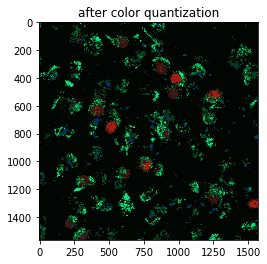

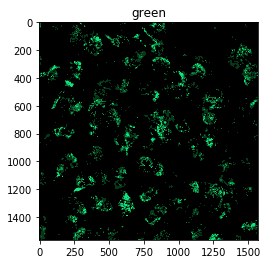

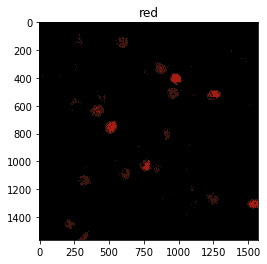

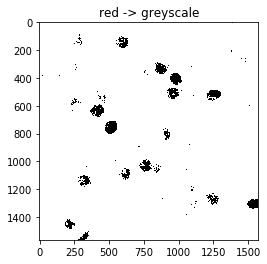

In [1]:
# pip install opencv-python

import cv2, os
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

path='./original.jpg'

orig = cv2.imread(path)


### kmeans color quantization: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html#color-quantization
img = orig
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(Z,8,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
# plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB));plt.title('colour clustered');plt.show()
orig = res2


# convert original to rgb and show it
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(orig);plt.title('after color quantization');plt.show()
# convert to hsv for thresholds
hsv = cv2.cvtColor(orig, cv2.COLOR_BGR2HSV)

# extract green
mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255)) > 0  # green
masked = np.zeros_like(orig, np.uint8)
masked[mask] = orig[mask]
plt.imshow(masked);plt.title('green');plt.show()

# extract red
mask = cv2.inRange(hsv, (100,25,0), (179,255,255)) > 0  # red
masked = np.zeros_like(orig, np.uint8)
masked[mask] = orig[mask]
plt.imshow(masked);plt.title('red');plt.show()

# make background white
black_mask = cv2.inRange(masked, (0,0,0), (50,50,50)) == 0
masked[black_mask] = [255]
masked = cv2.bitwise_not(masked)  # invert
plt.imshow(masked);plt.title('red -> greyscale');plt.show()


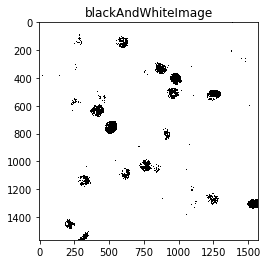

Estimated number of clusters: 14
Estimated number of noise points: 5536


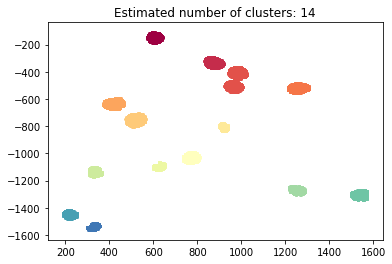

In [2]:
import numpy as np
from sklearn.cluster import DBSCAN

# convert to balck and white
gray = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)
blackAndWhiteImage = cv2.bitwise_not(blackAndWhiteImage)
plt.imshow(blackAndWhiteImage, cmap='gray_r');plt.title('blackAndWhiteImage');plt.show()
assert all([len(set(r)) <=2 for r in blackAndWhiteImage])

# convert black pixels to coordinates
coords = np.column_stack(np.where(gray < 1))

# Compute DBSCAN
X = coords
db = DBSCAN(eps=30, min_samples=1000).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], -xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor=tuple(col), markersize=2)

    # render noise 
    # if k == -1:
    #    col = [1, 1, 1, 1]  # white
    # xy = X[class_member_mask & ~core_samples_mask]
    # plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
